### **CMSE 201 Final Project**
#### Matthew Artuso
#### Section_005
#### 3 December 2019

# Applying Data Analytics and Machine Learning to Baseball

## Contents

1. [Background and Motivation](#Background_and_Motivation)


2. [Methodology](#Methodology)
    
    2.1. [Investigating the Correctness of Umpires](#Investigating)
    
    2.2. [Classifying Pitches with Sci-Kit Learn](#Classifying1)
    
    2.3. [Multi-Class Classification](#Classifying2)

    
3. [Results](#Results)


4. [Discussion and Conclusion](#Discussion)


5. [References](#References)

In [2]:
## Import modules for part 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as figure
import matplotlib.patches as pat
import seaborn as sns
%matplotlib inline

<a id='Data_Overview'></a>
### Data Overview
This dataset is from user Kaggle user Paul Schale:
>https://www.kaggle.com/pschale/mlb-pitch-data-20152018

He scraped this data from an MLB data bank found here:
>http://gd2.mlb.com/components/game/mlb/


This dataset has two files we will look at (although more are present). First, there is a pitches.csv that contains every pitch thrown from 2015 to 2018 and contains the majority of the data that will be used, such as pitch location, speed, and what it was called at home plate. This data has an ab_id column (an ID for the at-bat) such that we can match it up with the second data file, atbats.csv. Although the at-bats data also has a lot of information, we will primarily use this data to get pitcher handedness, something pitches.csv does not have. 

Also, some important terminology for those unfamiliar with baseball:
- Breaking Ball - A pitch that curves as it approaches the batter
- Break Length - How far the pitch moves from a straight trajectory


In [3]:
pitches = pd.read_csv('data/pitches.csv') ## Imports pitches

In [4]:
atbats = pd.read_csv('data/atbats.csv') ## Import the atbats data

In [5]:
# Look at data
pitches.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [6]:
## Get columns
pitches.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [7]:
pitches.shape

(2867154, 40)

In [8]:
atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [9]:
atbats.shape

(740389, 11)

In [10]:
pitches = pitches.dropna() ## Drops any empty values

In [11]:
pitches.describe()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
count,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,...,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06,2.847250e+06
mean,6.643277e-03,2.254971e+00,8.838152e+01,8.136265e+01,1.731086e+03,1.802457e+02,5.862024e+00,6.601393e+00,2.381687e+01,-2.314437e+00,...,3.126966e+02,2.254690e+00,2.016605e+09,8.807361e-01,8.830977e-01,9.812180e-01,2.895050e+00,3.025217e-01,1.845721e-01,9.488032e-02
std,8.927168e-01,9.464012e-01,6.015354e+00,5.363923e+00,6.827929e+02,6.742597e+01,2.443174e+01,1.333043e+02,6.445706e-02,1.073814e+01,...,1.927248e+02,2.550695e+00,1.116511e+06,9.654741e-01,8.250264e-01,8.174910e-01,1.727632e+00,4.593500e-01,3.879501e-01,2.930496e-01
min,-1.054333e+01,-5.183664e+00,3.390000e+01,3.240000e+01,1.214000e+00,-2.000000e-03,-9.000000e+01,1.000000e-01,2.330000e+01,-5.929009e+01,...,3.000000e+00,0.000000e+00,2.015000e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-5.906339e-01,1.650000e+00,8.430000e+01,7.790000e+01,1.238646e+03,1.371860e+02,-1.190000e+01,4.300000e+00,2.380000e+01,-1.129300e+01,...,1.490000e+02,0.000000e+00,2.016004e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.300000e-02,2.259003e+00,8.970000e+01,8.250000e+01,1.866259e+03,1.959150e+02,6.800000e+00,6.000000e+00,2.380000e+01,-3.150000e+00,...,3.020000e+02,1.000000e+00,2.017004e+09,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.090000e-01,2.863000e+00,9.300000e+01,8.540000e+01,2.247466e+03,2.252380e+02,2.710000e+01,8.000000e+00,2.390000e+01,5.986000e+00,...,4.640000e+02,3.000000e+00,2.018002e+09,2.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.295291e+01,1.488624e+01,1.050000e+02,9.690000e+01,6.539259e+03,3.600010e+02,2.694000e+02,2.248893e+05,3.640000e+01,4.097800e+01,...,1.336000e+03,2.500000e+01,2.018186e+09,4.000000e+00,2.000000e+00,2.000000e+00,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00


We can also look at some data and see how some of these are distributed.

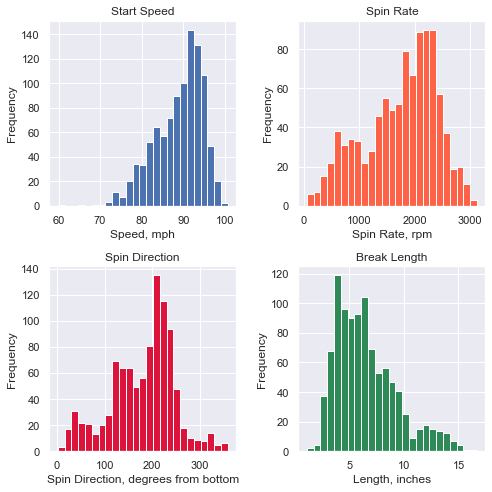

In [12]:
sns.set()
fig, ax = plt.subplots(2,2, figsize = (7,7))
ax[0,0].hist(pitches.sample(1000)['start_speed'], bins = 25)
ax[0,0].set_title('Start Speed')
ax[0,0].set_xlabel('Speed, mph')
ax[0,0].set_ylabel('Frequency')
ax[0,1].hist(pitches.sample(1000)['spin_rate'], bins = 25, color = 'tomato')
ax[0,1].set_title('Spin Rate')
ax[0,1].set_xlabel('Spin Rate, rpm')
ax[0,1].set_ylabel('Frequency')
ax[1,0].hist(pitches.sample(1000)['spin_dir'], bins = 25, color = 'crimson')
ax[1,0].set_title('Spin Direction')
ax[1,0].set_xlabel('Spin Direction, degrees from bottom')
ax[1,0].set_ylabel('Frequency')
ax[1,1].hist(pitches.sample(1000)['break_length'], bins = 25, color = 'seagreen')
ax[1,1].set_title('Break Length')
ax[1,1].set_xlabel('Length, inches')
ax[1,1].set_ylabel('Frequency')



plt.tight_layout()

***
<a class="anchor" id="Classifying1"></a>
## 2.2 Classifying Pitches with Sci-kit Learn

**Note:** A few resources are important to mention here. This is my first project using the Random Forest Classification module from scikit-learn, and this article by Usman Malik was phenomenally helpful in setting everything up:
>https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

And, of course, the scikit-learn documentation was also very helpful, along with Google's Machine Learning Crash Course:

>https://scikit-learn.org/stable/documentation.html

>https://developers.google.com/machine-learning/crash-course

***
### Creating a Guesser
First, let's create a baseline to compare our classifier to. This function essentially takes data, calculates the frequency of each pitch, and will then randomly guess pitches based on how often they appear. 

In [13]:
from numpy.random import choice

In [14]:
def guesser(data):
    ## Calculates the relative frequency as percent of total
    ## Stores in dictionary 'percents' in format pitch:percent
    freq = data['pitch_type'].value_counts().to_dict() ## Dictionary of pitches and frequency
    total = data.shape[0]
    percents = {}
    for key in freq:
        occurence = int(freq[key])
        per = occurence/total
        percents[key] = per

    ## Also populate lists with pitches and frequencies
    pitches = []
    freqs = []
    for key in percents:
        pitches.append(key)
        freqs.append(percents[key])
    
    ## Now, to guess, lets simply use the choose function from numpy
    correct = 0      # These are counters to keep track of correct and incorrect
    incorrect = 0
    
    for pitch in data['pitch_type']:
        guess = choice(pitches, p = freqs) # P is where we pass in frequency
        
        ## Below just guesses four-seam fastball. This is commented out currently.
        #guess = choice(['FF']) 
        
        if guess == pitch:
            correct += 1
        else:
            incorrect += 1        
    
    return correct/total, incorrect/total, percents ## Returns percentages of correct/incorrect and frequency of pitches

In [18]:
correct, incorrect, percents = guesser(pitches.sample(10000))
print('Correct %:', correct, '    Incorrect %:', incorrect)
print(percents) 

Correct %: 0.1852     Incorrect %: 0.8148
{'FF': 0.3551, 'SL': 0.1569, 'FT': 0.121, 'CH': 0.0994, 'SI': 0.0865, 'CU': 0.081, 'FC': 0.0526, 'KC': 0.0258, 'FS': 0.0154, 'KN': 0.004, 'IN': 0.0013, 'FO': 0.0007, 'PO': 0.0001, 'SC': 0.0001, 'EP': 0.0001}


You would actually be more accurate just guessing "four-seam fastball" everytime. This is called a Zero Rule algorithm (ZeroR), and is the recommended baseline for a classification problem. Let's set out baseline somewhere around 36% for ZeroR and set the baseline for actually guessing at ~20%. Removing the probability argument from the 'choice' function gives an accuracy of only 5%. 

***
### Random Forest

Let's start on the machine learning portion. Two things to start — first, import our libraries (as mentioned, we will use sci-kit learn). Second, using the RandomForestClassifier class, create a simple function that guesses if some coloumn is True or False (1 or 0) based on data that has some influence on that column. It also takes how many trees we want to generate. More trees usually means a more accurate classifier, but computation time is the limiting factor. 

A random forest classifier will be used to classify pitches. In essence, a random forest is a collection of decision trees that each guess a class, and the class that receives that majority of votes is the chosen class of the forest. Decision trees work by asking if the data meets certain criteria as it moves down the tree, either true or false at each node. 

<div>
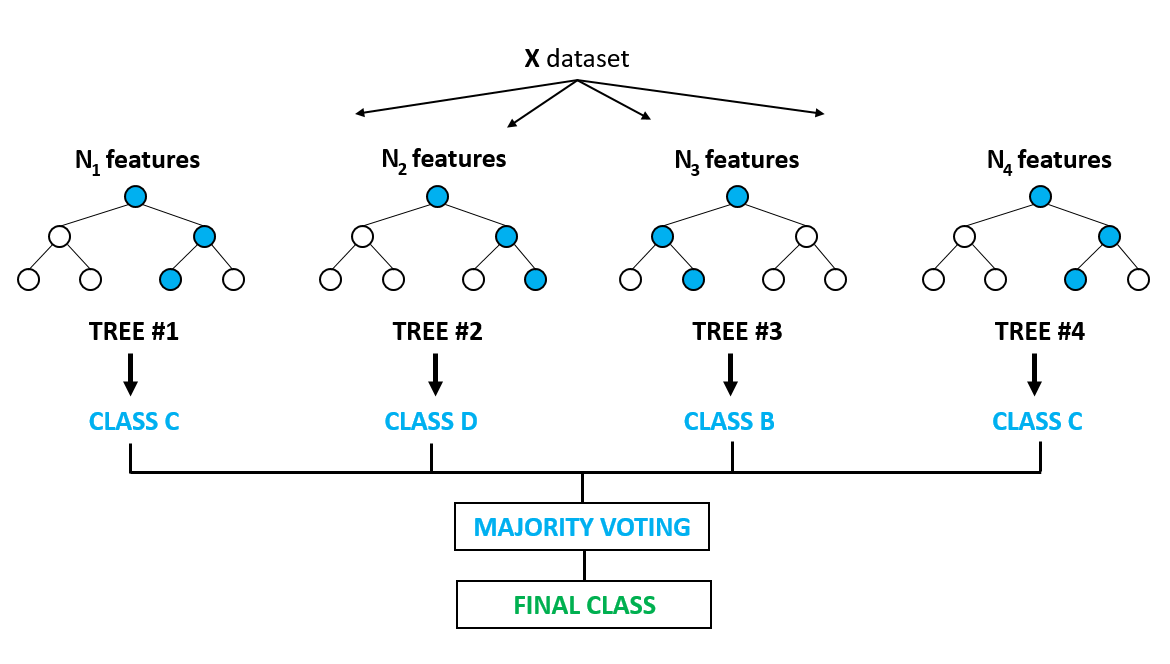
</div>
<i><font size="-1"><center> Adapted from https://www.globalsoftwaresupport.com/random-forest-classifier/
</center></font></i>
<br>

In [19]:
## Imports sklean modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [20]:
## This is the main function that will be used to classify pitches
## Trains a random forest classifier, returns how accurate it is
def predict(xdata, ydata, trees = 5, n_jobs = -1, depth = None, features = 'auto', class_weight = None):
    ## Splits into train and test data
    X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=0)
    
    ## initializes our classifier
    classify = RandomForestClassifier(n_estimators=trees, random_state=0, max_depth = depth, 
                                      max_features = 'auto', class_weight = class_weight)
    classify.fit(X_train, y_train) ## Trains it 
    y_pred = classify.predict(X_test) ## Predicts y's from test X data
    return accuracy_score(y_test, y_pred) ## Returns how many guesses are correct

**But, some important things first:**

First, let's add handedness of the pitcher to the "pitches" dataframe. This might be very important. Handedness affects which way pitches both spin and break; a left-handed pitcher's curveball will break into a right-handed batter, and vice versa. However, this data only exists in the "atbats" dataframe. To move this data over, we create a large dictionary that has every atbat ID and the handedness of that pitcher; we then match this to the atbat ID's of the pitches dataframe. 

In [21]:
## Creates a dictionary using the ID and the handedness of a pitcher
mydict = dict(zip(atbats['ab_id'], atbats['p_throws']))

## With help from https://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary
## User 'praful gupta', licensed under CC BY_SA 3.0
## https://stackoverflow.com/users/6096272/praful-gupta

In [22]:
## Maps either R or L from the dictionary, then re-maps R to 1 and L to 0 
## so that our classifier can use the data. 
pitches['handedness'] = pitches['ab_id'].map(mydict) 
pitches['handedness'] = pitches['handedness'].map({'R': 1, 'L': 0})

## With help from https://stackoverflow.com/questions/25570147/add-new-column-based-on-boolean-values-in-a-different-column
## User "EdChum - Reinstate Monica", licensed under CC BY_SA 3.0
## https://stackoverflow.com/users/704848/edchum-reinstate-monica

**And,** let's create a True/False column for every possible pitch. This will be the ydata we feed to the function so it has something to guess. Furthermore, let's drop rare pitches, especially ones that can be hard to distinguish, like pitchouts.

In [23]:
pitch_types = pitches['pitch_type'].unique()
for pitch in pitch_types:
    pitches[pitch] = (pitches['pitch_type'] == pitch).astype(int)

In [24]:
# Dropping rare pitches
rare_pitches = ['EP', 'FO', 'PO', "SC", 'UN', 'AB', "FA", "IN"]
pitches_common = pitches.copy()

for pitch in rare_pitches:
    pitches_common = pitches_common.drop(columns = pitch)
    pitches_common = pitches_common[pitches_common['pitch_type'] != pitch]

In [25]:
righthanded = pitches[pitches['handedness'] == 1] ## Only Right-handed pitches

***
### Feature Selection
To have our algorithm perform the best it can, we need to figure out quantities that actually distinguish pitches. If we give the classifier a bunch of 'xdata' that actually doesn't matter, the algorithm will perform worse, or simply just be less time efficient. We need to single out high-quality correlations.

Sci-kit Learn has methods to do just this, but instead will we take a simpler approach: visualization.

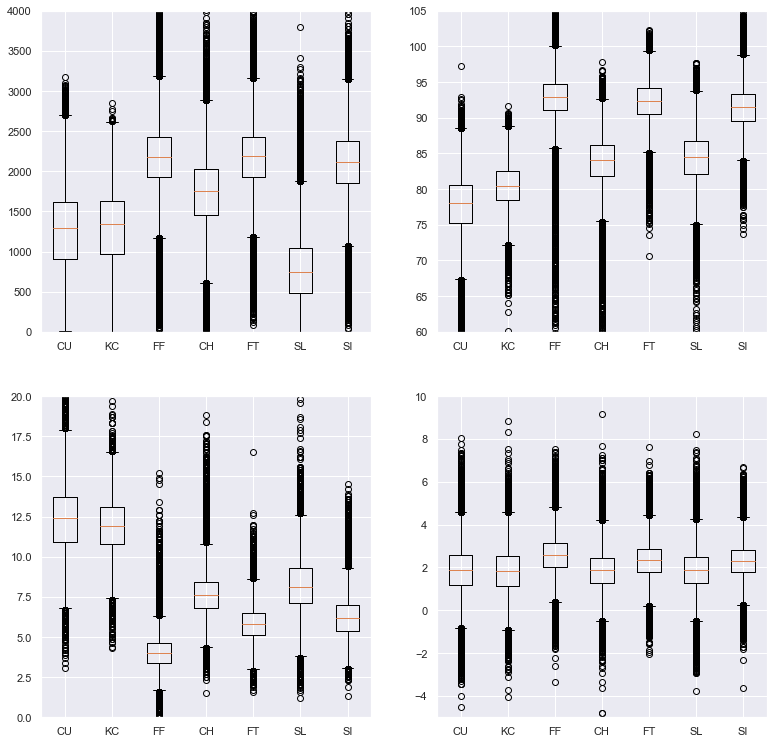

<Figure size 432x288 with 0 Axes>

In [26]:
fig, ax = plt.subplots(2,2, figsize = (13,13))

value = 'spin_rate'
ax[0,0].boxplot([pitches_common[pitches_common['CU'] == 1][value], 
             pitches_common[pitches_common['KC'] == 1][value],
             pitches_common[pitches_common['FF'] == 1][value],
             pitches_common[pitches_common['CH'] == 1][value],
             pitches_common[pitches_common['FT'] == 1][value],
             pitches_common[pitches_common['SL'] == 1][value],
             pitches_common[pitches_common['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[0,0].set_ylim(0,4000)

value = 'start_speed'
ax[0,1].boxplot([pitches_common[pitches_common['CU'] == 1][value], 
             pitches_common[pitches_common['KC'] == 1][value],
             pitches_common[pitches_common['FF'] == 1][value],
             pitches_common[pitches_common['CH'] == 1][value],
             pitches_common[pitches_common['FT'] == 1][value],
             pitches_common[pitches_common['SL'] == 1][value],
             pitches_common[pitches_common['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[0,1].set_ylim(60,105)
plt.savefig('ex.png', dpi = 300)

value = 'break_length'
ax[1,0].boxplot([pitches_common[pitches_common['CU'] == 1][value], 
             pitches_common[pitches_common['KC'] == 1][value],
             pitches_common[pitches_common['FF'] == 1][value],
             pitches_common[pitches_common['CH'] == 1][value],
             pitches_common[pitches_common['FT'] == 1][value],
             pitches_common[pitches_common['SL'] == 1][value],
             pitches_common[pitches_common['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[1,0].set_ylim(0,20)

value = 'pz'
ax[1,1].boxplot([pitches_common[pitches_common['CU'] == 1][value], 
             pitches_common[pitches_common['KC'] == 1][value],
             pitches_common[pitches_common['FF'] == 1][value],
             pitches_common[pitches_common['CH'] == 1][value],
             pitches_common[pitches_common['FT'] == 1][value],
             pitches_common[pitches_common['SL'] == 1][value],
             pitches_common[pitches_common['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[1,1].set_ylim(-5,10)


plt.show()
plt.tight_layout()

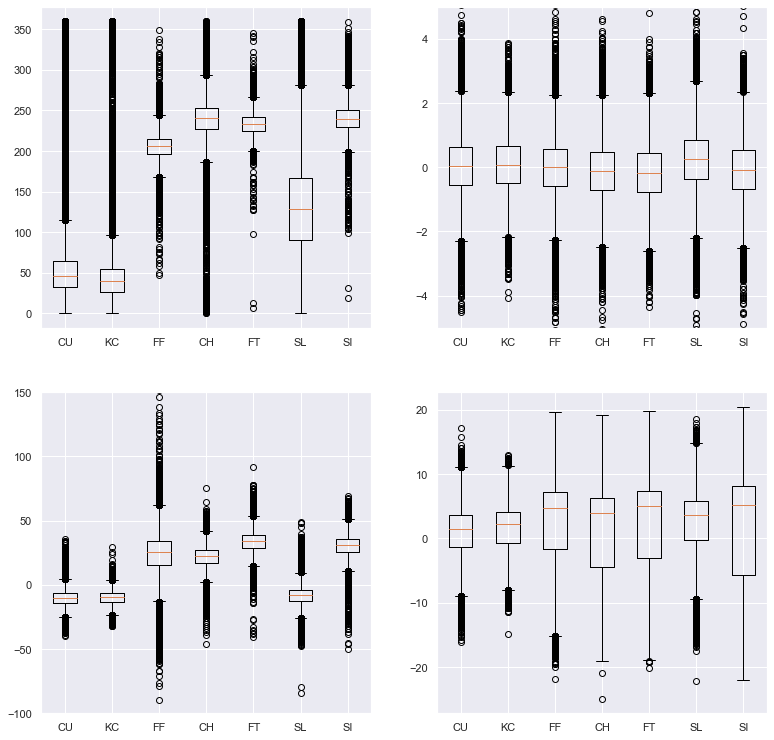

<Figure size 432x288 with 0 Axes>

In [27]:
fig, ax = plt.subplots(2,2, figsize = (13,13))

## Note that for spin direction and break angle we single the data to right handers. 
## This is because a curveball from a right hander will break into a left handed batter, and vice versa. 
value = 'spin_dir'
ax[0,0].boxplot([righthanded[righthanded['CU'] == 1][value], 
             righthanded[righthanded['KC'] == 1][value],
             righthanded[righthanded['FF'] == 1][value],
             righthanded[righthanded['CH'] == 1][value],
             righthanded[righthanded['FT'] == 1][value],
             righthanded[righthanded['SL'] == 1][value],
             righthanded[righthanded['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[0,0].set_ylim()

value = 'px'
ax[0,1].boxplot([pitches_common[pitches_common['CU'] == 1][value], 
             pitches_common[pitches_common['KC'] == 1][value],
             pitches_common[pitches_common['FF'] == 1][value],
             pitches_common[pitches_common['CH'] == 1][value],
             pitches_common[pitches_common['FT'] == 1][value],
             pitches_common[pitches_common['SL'] == 1][value],
             pitches_common[pitches_common['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[0,1].set_ylim(-5,5)

value = 'break_angle'
ax[1,0].boxplot([righthanded[righthanded['CU'] == 1][value], 
             righthanded[righthanded['KC'] == 1][value],
             righthanded[righthanded['FF'] == 1][value],
             righthanded[righthanded['CH'] == 1][value],
             righthanded[righthanded['FT'] == 1][value],
             righthanded[righthanded['SL'] == 1][value],
             righthanded[righthanded['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[1,0].set_ylim(-100, 150)

value = 'vx0'
ax[1,1].boxplot([pitches_common[pitches_common['CU'] == 1][value], 
             pitches_common[pitches_common['KC'] == 1][value],
             pitches_common[pitches_common['FF'] == 1][value],
             pitches_common[pitches_common['CH'] == 1][value],
             pitches_common[pitches_common['FT'] == 1][value],
             pitches_common[pitches_common['SL'] == 1][value],
             pitches_common[pitches_common['SI'] == 1][value]],
           labels = ['CU', 'KC', 'FF', 'CH', 'FT', 'SL', 'SI'])
ax[1,1].set_ylim()


plt.show()
plt.tight_layout()

It appears that everything is a pretty good indicator, except for three: position over plate (px), vx0, and pz. Spin rate seems to mostly classify breaking balls from other pitches. 

Notice something that may throw off our algorithm: Curveballs (CU) and Knucklecurves (KC) have very similar characteristics, perhaps because they are just a variation of the same pitch (indeed, only the index finger position is different). Likewise for the sinker and the 2-seam fastball. I wonder why the data splits these up. To account for this, we will combine these pitches together when doing multi-class classification. 

***
### Testing the Algorithm
Now let's see how the classifier performs for a few individual pitches:

In [29]:
train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']
correct_percent = predict(pitches[train_columns], pitches['FF'])
print('Guessed fastball correctly', round(correct_percent*100, 2), 'percent of the time.')

Guessed fastball correctly 89.33 percent of the time.


In [30]:
train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']
correct_percent = predict(pitches[train_columns], pitches['CH'])
print('Guessed changeup correctly', round(correct_percent*100, 2), 'percent of the time.')

Guessed changeup correctly 94.87 percent of the time.


In [122]:
train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']
correct_percent = predict(pitches[train_columns], pitches['SL'])
print('Guessed slider correctly', round(correct_percent*100, 2), 'percent of the time.')

Guessed slider correctly 91.77 percent of the time.


In [123]:
train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']
correct_percent = predict(pitches[train_columns], pitches['CU'])
print('Guessed curveball correctly', round(correct_percent*100, 2), 'percent of the time.')

Guessed curveball correctly 95.12 percent of the time.


<a class="anchor" id="Classifying2"></a>
***
## 2.3 Multi-class Classification
We can greatly improve on this method: instead of just asking our algorithm if a given pitch is pitch 'x', what if we fed it a pitch and made it choose which pitch it was? We will acomplish this by altering our classifier to make it multi-class. We will start by assigning all of the pitches to a numerical identifier, similar to how we previously assigned True/False to 1 or 0 for each pitch.

In [32]:
## For multi-class classification, we map a new column to numerical representations of pitches
## Lets combine similar pitches, so note that 'KC' and 'CH' are both assigned to 0, likewise for 'FT' and 'SI'
mapping = {'CH': 0, 'CU': 1, 'FF': 2, 'FC': 3, 'SI': 4, 'FT': 4, 'SL': 5, 'KC':0, 'FS': 6, 'KN': 7}
pitches_combined = pitches_common
pitches_combined['pitch_type_numeric'] = pitches_combined['pitch_type'].map(mapping)

*** 
Now its time to test our algorithm. Let's try to guess our combined dataset with 3 trees. The cell returns the percent that the algorithm got correct.

In [33]:
train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']
correct_percent = predict(pitches_combined[train_columns], pitches_combined['pitch_type_numeric'], trees = 3)
print('The classifier got', correct_percent*100, '% correct.')

The classifier got 73.0105720012823 % correct.


***
### Hyperparameter Tuning

The classifier got 73% correct. However, we only used three trees, and this score can definitely be improved. To do so, we will use a grid search to find the best values for the parameters of our algorithm. This is called "hyperparameter optimiztion". First we see how altering the amount of trees affects accuracy.

In [36]:
results2 = [] ## The accuracy
num2 = [] ## The number of trees used
for i in range(3, 33, 3):
    results2.append(predict(pitches_combined[train_columns], pitches_combined['pitch_type_numeric'], trees = i))
    num2.append(i)

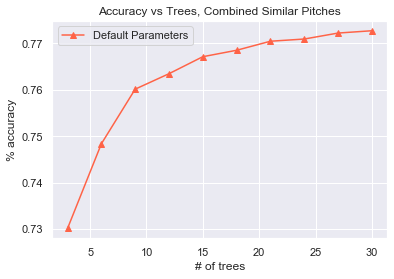

In [46]:
sns.set_style('darkgrid')
plt.plot(num2, results2, color = 'tomato', marker = '^', label = 'Default Parameters')
plt.xlabel('# of trees')
plt.ylabel('% accuracy')
plt.title('Accuracy vs Trees, Combined Similar Pitches')
plt.legend()
plt.savefig('Default.png', dpi=300)

**Grid Search**
<br>
Now we perform a grid search to find the best values for max_depth and max_features. max_depth determines how deep the decision trees go; max_features determines how many features are considered when splitting a node.

In [141]:
## These are values we will try
max_depth = [5, 10, 15]
max_features = [3, 4, None]

## Our train columns we've been using
train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']

## Splits our data as we usually do
X_train, X_test, y_train, y_test = train_test_split(pitches_combined[train_columns], 
                                                    pitches_combined['pitch_type_numeric'], test_size=0.2, random_state=0)

## Initializes the classifier
classify = RandomForestClassifier(n_estimators = 10, n_jobs = -1)

## These two lines will iterate through each combination of values that we set and will determine 
## the best combination. We call both that combination and the best accuracy.
grid = GridSearchCV(estimator = classify, cv = 3, param_grid=dict(max_depth = max_depth, max_features = max_features))
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn

In [142]:
grid.best_score_

0.7808059444247019

In [143]:
grid.best_params_

{'max_depth': 15, 'max_features': 3}

**And**, just to check that we shouldn't go any higher with "max_depth":

In [51]:
max_depth = [15, 18]

train_columns = ['start_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'handedness']

X_train, X_test, y_train, y_test = train_test_split(pitches_combined[train_columns], pitches_combined['pitch_type_numeric'], test_size=0.2, random_state=0)
classify = RandomForestClassifier(n_estimators = 10, n_jobs = -1)


grid2 = GridSearchCV(estimator = classify, cv = 3, param_grid=dict(max_depth = max_depth))
grid2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn

In [52]:
grid2.best_score_

0.7804844861136615

In [53]:
grid2.best_params_

{'max_depth': 15}

It appears that the best max_depth value is 15 and max_features is 3. Once again, let's test how n_estimators affects the accuracy now that the parameters are tuned:

In [54]:
results3 = []
num3 = []
for i in range(3, 33, 3):
    results3.append(predict(pitches_combined[train_columns], pitches_combined['pitch_type_numeric'], 
                            trees = i, depth = 15, features = 3))
    num3.append(i)

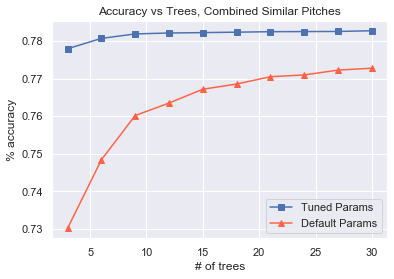

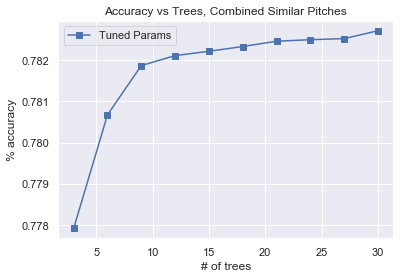

In [73]:
sns.set_style('darkgrid')
plt.figure(0)
plt.plot(num3, results3, label = 'Tuned Params', marker = 's')
plt.plot(num2, results2, color = 'tomato', label = 'Default Params', marker = '^')
plt.xlabel('# of trees')
plt.ylabel('% accuracy')
plt.title('Accuracy vs Trees, Combined Similar Pitches')
plt.legend()
plt.savefig('Combined.png', dpi = 300)

plt.figure(1)
plt.plot(num3, results3, label = 'Tuned Params', marker = 's')
plt.xlabel('# of trees')
plt.ylabel('% accuracy')
plt.title('Accuracy vs Trees, Combined Similar Pitches')
plt.legend()
plt.savefig('Hyper.png', dpi = 300)

<a class="anchor" id="Results"></a>
***
## 3. Results


**Pitch Classification**
<br>
Overall, the classifier seems to be very successful. Accuracy of over 78% is decent — especially considering that guessing based off frequency of pitches yields only 20% and ZeroR is 36% accurate. 

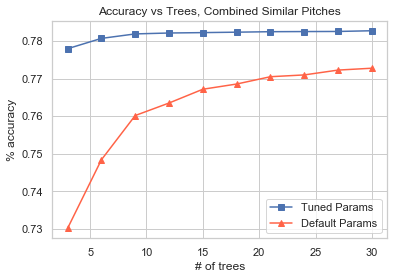

In [137]:
sns.set_style('whitegrid')
plt.figure(0)
plt.plot(num3, results3, label = 'Tuned Params', marker = 's')
plt.plot(num2, results2, color = 'tomato', label = 'Default Params', marker = '^')
plt.xlabel('# of trees')
plt.ylabel('% accuracy')
plt.title('Accuracy vs Trees, Combined Similar Pitches')
plt.legend()

One of the more interesting results is how much better the performance is when we tune hyperparameters. Even three tuned trees is more accurate than thirty trees with default parameters. 

***
<a class="anchor" id="Discussion"></a>
## 4. Discussion and Conclusion

Regarding the apparent umpire bias when calling pitches, the MLB should look into solidifying its guidelines so both batters and pitchers know what to expect. Or, a computerized system similar to what I created here might be used instead of an umpire altogether. The game could be greatly improved — missing 12% of calls is unacceptable. 

While classifying pitches may be an interesting project, it still has limited use. Perhaps the only use might be to quickly display on a broadcast which pitch was just thrown. Other machine learning applications may prove to be more useful. One of these, which I might attempt in the future, is predicting the next pitch that will be thrown. However, this is technically illegal in the MLB. The use of technology like this is prohibited, such as the use of the midfield camera to steal signs by the World Series winning Astros team. Former NASA engineer and current entertainer Mark Rober has done something similar: he created a phone app that uses machine learning to steal stealing signs (the third base coach will signal to the first base runner if he should steal second base or not). Rober used a neural net for this purpose, something else that should be tried for both classifying pitches and guessing the next pitch. 

***
**Drawbacks of both methods**

One large drawback of the masking method for ball-strike calls is the use of the universal strike zone. In reality, players are different heights, and so the height of the strike zone changes. The strike zone usually extends from the bottom of the knee cap to the midpoint between their waist and shoulders. But as shown, most incorrect calls have to do with width, not height, and the strike zone remains a contant width. 

My method of classifying pitches also has its problems. The only metric used to evaluate the classifier, accuracy, can be very flawed. For example, if a fastball is only thown 5% of the time, and the classifier can guess if a fastball was thrown  with 95% accuracy, then this actually is not very impressive. The classifier really only could have guessed "false" everytime to get that level of accuracy. This is also why so little time was spent on single-class classification. In the future I would like to implement more advanced evaluation metrics to further improve performance. Furthermore, I would like to investigate how to better do machine learning problems where the classes have very uneven frequency. I also plan to verify the common thought that scaling the data has no effect on performance.


***
## 5. References
(EdChum - Reinstate Monica). "Add new column based on boolean values in a different column" #25570219 . 29 August 2019. Forum post. https://stackoverflow.com/questions/25570147/add-new-column-based-on-boolean-values-in-a-different-column

Lutins, Evan. “Grid Searching in Machine Learning: Quick Explanation and Python Implementation.” Medium, 5 Sept. 2017, https://medium.com/@elutins/grid-searching-in-machine-learning-quick-explanation-and-python-implementation-550552200596.

Malik, Usman. “Random Forest Algorithm with Python and Scikit-Learn.” Stack Abuse, 13 June 2018, https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/.

(praful gupta). "python pandas dataframe to dictionary" #39837358 . 3 October 2016. Forum post. https://stackoverflow.com/questions/18695605/python-pandas-dataframe-to-dictionary/39837358#39837358

Schale, Paul. “MLB Pitch Data 2015-2018.” Kaggle, 12 Dec. 2018, https://www.kaggle.com/pschale/mlb-pitch-data-20152018.